In [16]:
using Pkg; Pkg.activate(".")
using Plots
using BenchmarkTools
import Markdown; Base.showable(::MIME"text/markdown", ::Markdown.MD) = false # to make sth like """?replace"""  works for vscode backend, remember to choose Jupyter kernel
include("bnc_initialize.jl")
Threads.nthreads() # check number of threads

  Activating project at `/mnt/d/Non-implementary-index/bnc_julia`


24

In [23]:
# #binding
N = [2 1 -1]
x_sym = [:E, :S, :C]
q_sym = [:tE, :tS]
K_sym = [:K]

model = Bnc(N = N, x_sym=x_sym, q_sym=q_sym, K_sym=K_sym)

Bnc([2 1 -1], [1 0 2; 0 1 1], 1, 3, 2, Num[E, S, C], Num[tE, tS], Num[K], -1, nothing, [0.0, 0.0, 0.0], [0.47712125471966244, 0.3010299956639812, 0.0], false, sparse([1, 3, 2, 3], [1, 1, 2, 2], [1.0, 2.0, 1.0, 1.0], 3, 2), sparse([1, 3, 2, 3, 1, 2, 3], [1, 1, 2, 2, 3, 3, 3], [1.0, 2.0, 1.0, 1.0, 2.0, 1.0, -1.0], 3, 3), SparseArrays.UMFPACK.UmfpackLU{Float64, Int64}(SparseArrays.UMFPACK.Symbolic{Float64, Int64}(Ptr{Nothing} @0x00000000040ec2d0), SparseArrays.UMFPACK.Numeric{Float64, Int64}(Ptr{Nothing} @0x0000000006fab4a0), 3, 3, [0, 2, 4, 7], [0, 2, 1, 2, 0, 1, 2], [1.0, 2.0, 1.0, 1.0, 2.0, 1.0, -1.0], 0, SparseArrays.UMFPACK.UmfpackWS{Int64}([138810252443480, 158913790859, 138810102471760], [6.85813770228744e-310, 7.85138447143e-313, 0.0]), [1.0, 0.2, 0.2, 0.1, 32.0, 0.0, 0.7, 0.0, 1.0, 0.3, 1.0, 1.0, 0.9, 0.0, 10.0, 0.001, 1.0, 0.5, 0.0, 1.0], [0.0, 3.0, 7.0, 16.0, 4.0, 8.0, 8.0, 8.0, 0.0, 0.0  …  -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0], ReentrantLock(nothing, 0x0

In [24]:
model.L

2×3 Matrix{Int64}:
 1  0  2
 0  1  1

In [5]:
# add labels to the regimes
function label(data)
    # Get the unique items from the input data
    items = unique(data)
    # Initialize an empty dictionary. Julia will infer the types.
    group_map = Dict() 
    # Enumerate the unique items and assign an integer label to each
    for (i, item) in enumerate(items)
        # Use assignment (=) instead of the pair operator (=>)
        group_map[item] = i 
    end
    return group_map
end

minx = -6
maxx = 6
points = 100

logq_rg = range(minx,maxx,points)
q = collect(Base.product(exp10.(logq_rg), exp10.(logq_rg)))
shape = size(q)
q = stack(q[:],dims=1)

# q = begin
#     rg1 = exp10.(-2:(4/100):2)
#     q = collect(Base.product(rg1,rg1))
#     stack(q[:],dims=1)
# end   # Generate random q values

x = qK2x(model,q',K=[1],alg_hints=[:stiff])' # Convert q to x with K=1'
# Find the regime of x
regimes = get_regime(model, x, q)
regime_labels = label(regimes)
labels = map(g-> regime_labels[g], regimes)
labels_lattice = Float64.(reshape(labels, shape))


using ImageFiltering
convolved_data = imfilter(labels_lattice, Kernel.Laplacian(), "replicate") # findboundary
edge_map = convolved_data .!= 0
print("Done")


Done

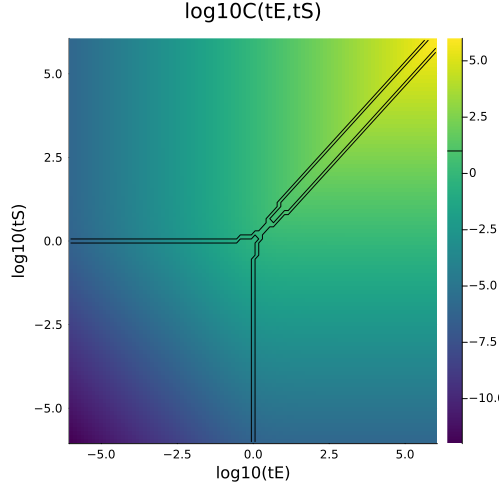

In [6]:
using Plots; #pythonplot()

    
# scatter(log10.(q[:,1]),log10.(q[:,2]),zcolor = log10.(x[:,3]),
#     xlabel="log10(tE)", ylabel="log10(tS)",
#     # title="BNC model with K=1",
#     xticks = (-2:0.5:2), yticks = (-2:0.5:2),
#     clims = (0,3), c=:black, cbar=false,
#     size = (700,600), legend=false)

heatmap(logq_rg, logq_rg,log10.(reshape(x[:,3],shape)),colormap=:viridis,size=(500,500),)
# plot!([-2,0],[0,0],line=(1.5,:dash,:red))
# plot!([0,0],[-2,0],line=(1.5,:dash,:red))
# plot!([0,2],[0,2],line=(1.5,:dash,:red),legend=false)
contour!(logq_rg, logq_rg,edge_map,levels=[0.999],color=[:black],size = (500,500))
# annotate!(-1.5,-1.5, "①")
# annotate!(-1.5,1.5, "②")
# annotate!(1.5,-1.5, "③")
# annotate!(1.5,1.5,"④")

# plot!([-2,0],[0,0],line=(4,:dash,0.6,:red))
xlabel!("log10(tE)")
ylabel!("log10(tS)")
title!("log10C(tE,tS)")


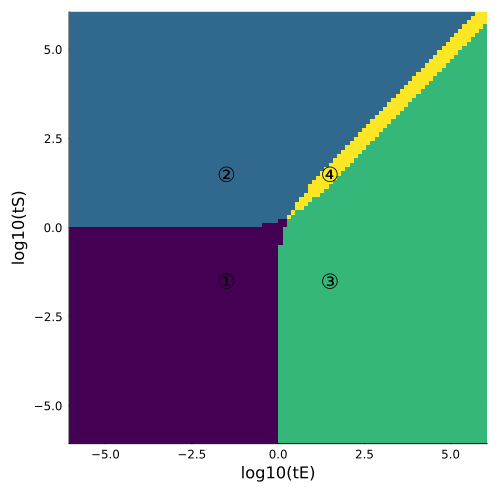

In [7]:
heatmap(logq_rg, logq_rg,labels_lattice,size=(500,500),legend=false,colormap=:viridis)
annotate!(-1.5,-1.5, "①")
annotate!(-1.5,1.5, "②")
annotate!(1.5,-1.5, "③")
annotate!(1.5,1.5,"④")
xlabel!("log10(tE)")
ylabel!("log10(tS)")

In [25]:
valid_regimes = find_valid_regime(model,recalculate=false)

4-element Vector{Vector{Int64}}:
 [1, 2]
 [1, 3]
 [3, 2]
 [3, 3]

In [26]:
model.valid_regimes

4-element Vector{Vector{Int64}}:
 [1, 2]
 [1, 3]
 [3, 2]
 [3, 3]

In [22]:
M_from_regime(model,[1,2])

2×3 Matrix{Int64}:
 1  0  0
 0  1  0

In [27]:
x_ineq_mtx(model,regime=[3,2])

2×3 Matrix{Int64}:
 1   0  -1
 0  -1   1

In [ ]:



x = log10.(q[:,1])
y = log10.(q[:,2])
z = Vector{Float64}(labels)
contourf(x, y, z)

In [23]:
# This is the struct that "belongs" to A.
struct B
    generated_from_id::Int
    data::String
end

# This is the main struct. It must be mutable to allow adding to the cache.
mutable struct A
    name::String
    b_cache::Dict{Int, B} # Caches B's using an Int as the key

    # Inner constructor to initialize the cache automatically
    A(name::String) = new(name, Dict{Int, B}())
end

In [24]:
function get_or_create_B(a::A, id::Int)
    # The 'get!' function is perfect for this lazy creation pattern.
    # The 'do ... end' block only runs if the key 'id' is NOT in the cache.
    get!(a.b_cache, id) do
        println("Cache miss! Creating a new B for id: $id...") # To show it's working

        # This is your "expensive operation" to create B
        sleep(0.5) # Simulate work
        new_data = "This is B data for id $id from A named '$(a.name)'"
        
        return B(id, new_data) # The return value is stored in the cache
    end
end

get_or_create_B (generic function with 1 method)

In [28]:
my_a = A("My First A",empty)

LoadError: MethodError: no method matching A(::String, ::typeof(empty))
The type `A` exists, but no method is defined for this combination of argument types when trying to construct it.

[0mClosest candidates are:
[0m  A(::String)
[0m[90m   @[39m [36mMain[39m [90m[4mIn[23]:13[24m[39m


In [26]:
my_a.b_cache

Dict{Int64, B}()

In [ ]:
# Create an instance of A


# --- First call for id = 10 ---
println("Requesting B for id 10 the first time:")
b1 = get_or_create_B(my_a, 10)
println("Received: $(b1.data)\n")

Requesting B for id 10 the first time:


Cache miss! Creating a new B for id: 10...
Received: This is B data for id 10 from A named 'My First A'



In [20]:
println("Requesting B for id 10 the second time:")
b2 = get_or_create_B(my_a, 10)
println("Received: $(b2.data)\n")

Requesting B for id 10 the second time:
Received: This is B data for id 10 from A named 'My First A'



In [21]:
println("Requesting B for id 25:")
b3 = get_or_create_B(my_a, 25)
println("Received: $(b3.data)\n")

Requesting B for id 25:
Cache miss! Creating a new B for id: 25...
Received: This is B data for id 25 from A named 'My First A'



In [22]:
@assert b1 === b2 # This checks they are the same object in memory
@assert b1 !== b3 # This checks they are different objects

# You can inspect the cache directly
println("Final state of cache in 'my_a':")
println(my_a.b_cache)

Final state of cache in 'my_a':
Dict{Int64, B}(25 => B(25, "This is B data for id 25 from A named 'My First A'"), 10 => B(10, "This is B data for id 10 from A named 'My First A'"))
